# Fraud Detection on Bank Payments

## 1. Exploratory data Analysis

In [95]:
import pandas as pd 
import numpy as np
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

# sns.net()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

### Datos

Una vez hemos analizado los datos que tenemos de las transacciones históricas recogidas durante 6 meses (ver analisis.html), destacamos los siguientes resultados:

- Estamos ante un conjunto de datos estructurado.
- Tenemos como entrada (x) 594 643 datos de compras bancarias (big data).
- No tenemos transacciones duplicadas ni con valores perdidos.
- La salida (y) es una clasificación binaria: 0 = no fraude, 1 = fraude.
- Tenemos un total de 587 443 transacciones etiquetadas como no fraudes, y 7200 etiquetadas como fraudes. Es decir, un 1.2% de los datos son fraudes, lo que quiere decir que estamos ante un conjunto de datos desbalanceado.

En cuanto a los datos, tenemos 9 variables independientes y la variable dependiente (fraude no fraude)

- Step: Día desde el inicio de la recogida de transacciones (180 días = 6 meses).  Variable numérica discreta que va desde 0 hasta 180.
- Customer: Id del cliente. Variable categórica nominal. Tenemos 4 112 clientes diferentes.
- Age: Edad categorizada en 7 grupos.
    - 0: <= 18
    - 1: 19-25
    - 2: 26-35
    - 3: 36-45
    - 4: 46-55
    - 5: 56-65
    - 6: > 65
    - U: Unknown
- Gender: Género categorizado en 4 grupos.
    - E: Empresa
    - F: Female
    - M: Male
    - U: Unknown
- ZipCodeOrigin: Código postal. Variable categórica constante. Todas las muestras tienen el mismo valor.
- Merchant: Id comerciante. 50 categorías distintas.
- zipMerchant: Código postal del comerciante. Variable categórica constante. Todas las muestras tienen el mismo valor.
- Category: Categoría de la compra. 15 categorías distintas de la compra. Por ejemplo: transportes, salud, comida, otros, etc.
- Amount: Cantidad de la transacción. Variable numérica continua.
- Fraud: 1 = fraude. 0 = No fraude. Variable etiqueta.

In [96]:
# Cargar dataset
df = pd.read_csv("data/raw_data.csv")
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


Comprobamos que no tenemos ninguna muestra con valor nulo

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


Sabemos que tenemos los datos muy desbalanceados (como vemos en la gráfica generada). Para balancear los datos, podemos usar técnicas de submuestreo (reducir el número de muestras eliminando aleatoriamente muestras de la clase mayoritaria para igualar el número de muestras de la clase minoritaria ) y sobremuestreo (replicar aleatoriamente muestras de la clase minoritaria para igualar el número de muestras de la clase mayoritaria).

Vamos a aplicar una técnica de sobremuestreo denominada SMOTE, con el objetivo de balancear los datos. Con SMOTE, vamos a crear nuevos datos de la clase minoritaria utilizando las instancias vecinas, de modo que las muestras generadas no son copias exactas pero son similares a los datos que tenemos.

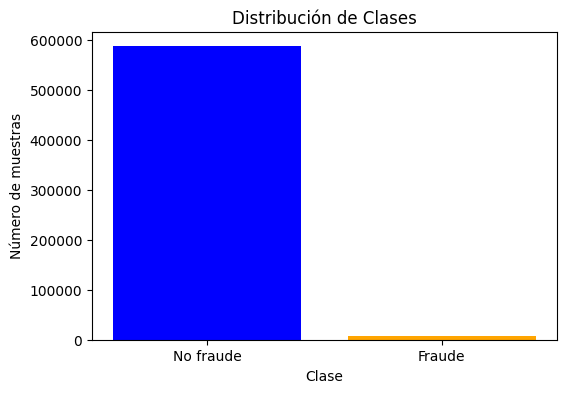

In [98]:
classes = df['fraud'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(classes.index, classes.values, color=['blue', 'orange'])
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.title("Distribución de Clases")
plt.xticks([0, 1], ["No fraude", "Fraude"])
plt.show()

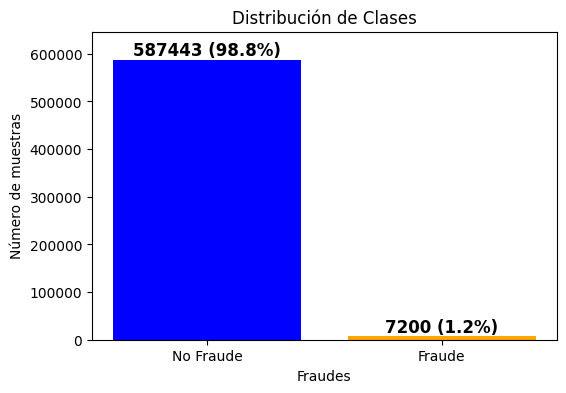

In [99]:
classes = df['fraud'].value_counts()
percentages = df['fraud'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
bars = plt.bar(classes.index, classes.values, color=['blue', 'orange'])

for bar, count, percent in zip(bars, classes.values, percentages.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f"{count} ({percent:.1f}%)", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Etiquetas
plt.xlabel("Fraudes")
plt.ylabel("Número de muestras")
plt.ylim(0, classes.max() * 1.1)
plt.title("Distribución de Clases")
plt.xticks([0, 1], ["No Fraude", "Fraude"])

plt.show()

## 2. Preprocesamiento de datos

### Selección de variables

Comenzamos el preprocesamiento de los datos con una selección de variables. Vamos a eliminar aquellas variables que no son relevantes ni predictivas:

- Variables constantes: zipCodeOri y zipMerchant tienen valores constantes, los valores son únicos para estas variables.

In [100]:
columns_to_drop = [
    "zipcodeOri", "zipMerchant", "step"
]

df = df.drop(columns=columns_to_drop)

df.columns

Index(['customer', 'age', 'gender', 'merchant', 'category', 'amount', 'fraud'], dtype='object')

In [101]:
df.head()

,customer,age,gender,merchant,category,amount,fraud
0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,'C757503768','5','M','M348934600','es_transportation',35.72,0


### Codificación de variables categóricas

Vamos a transformar las variables categóricas en numéricas. Hay distintos enfoques para realizar esto, como aplicar un one-hot encoding. En nuestro caso, vamos a optar por usar un label encoding, con el objetivo de asignar a cada categoría un número entero único. Por ejemplo, para la variable Gender con 4 categorías, vamos a asignar los valores de 0, 1, 2 y 3, cada valor refiriendose a una categoría.

In [102]:
columns = ["customer", "age", "gender", "merchant", "category"]

for col in columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
    
df.head()

,customer,age,gender,merchant,category,amount,fraud
0,210,4,2,30,12,4.55,0
1,2753,2,2,30,12,39.68,0
2,2285,4,1,18,12,26.89,0
3,1650,3,2,30,12,17.25,0
4,3585,5,2,30,12,35.72,0


In [103]:

X = df.drop(["fraud"], axis=1)
Y = df["fraud"]

X.head()



,customer,age,gender,merchant,category,amount
0,210,4,2,30,12,4.55
1,2753,2,2,30,12,39.68
2,2285,4,1,18,12,26.89
3,1650,3,2,30,12,17.25
4,3585,5,2,30,12,35.72


In [104]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64

NOTA: ver normalizado de datos, outliers, one-hot-encoding, etc.

## 3. Aplicación de SMOTE

Con el objetivo de balancear los datos debido al bajo número de muestras etiquetadas como fraudes, vamos a aplicar SMOTE de forma que tengamos el mismo número de muestras de fraudes y no fraudes.

In [105]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, Y)
y_res = pd.DataFrame(y_res)

In [106]:
y_res.value_counts()

fraud
0        587443
1        587443
Name: count, dtype: int64

c:\Users\javi2\Desktop\MUII\DISIA\Proyecto\git\Bank-Fraud-Detection\venv\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\javi2\Desktop\MUII\DISIA\Proyecto\git\Bank-Fraud-Detection\venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    234994
           1       0.99      1.00      1.00    234961

    accuracy                           1.00    469955
   macro avg       1.00      1.00      1.00    469955
weighted avg       1.00      1.00      1.00    469955



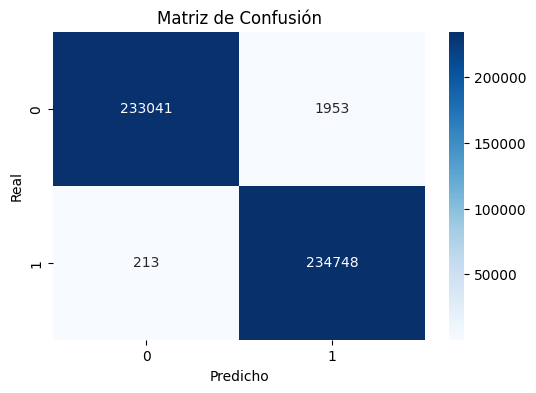

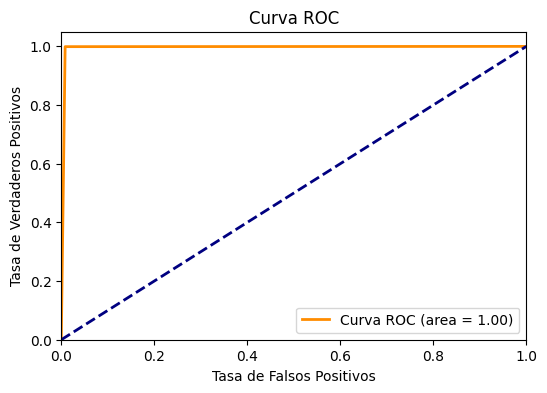

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.4, random_state=42)

# Modelos
xgb_model = xgb.XGBClassifier()
knn_model = KNeighborsClassifier(n_neighbors=3)
rf_model = RandomForestClassifier(n_estimators=100)

# Ensamble. Esto es un clasificador que combina los tres modelos anteriores. ¿Cómo funciona? El ensamble toma las predicciones de cada modelo y las combina para obtener una predicción final. En este caso, se utiliza la votación suave (soft voting), que consiste en promediar las probabilidades de cada modelo y seleccionar la clase con mayor probabilidad.
ensemble = VotingClassifier(estimators=[
    ('xgb', xgb_model), ('knn', knn_model), ('rf', rf_model)
], voting='soft')

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

--- Resultados para XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    234994
           1       0.99      1.00      0.99    234961

    accuracy                           0.99    469955
   macro avg       0.99      0.99      0.99    469955
weighted avg       0.99      0.99      0.99    469955



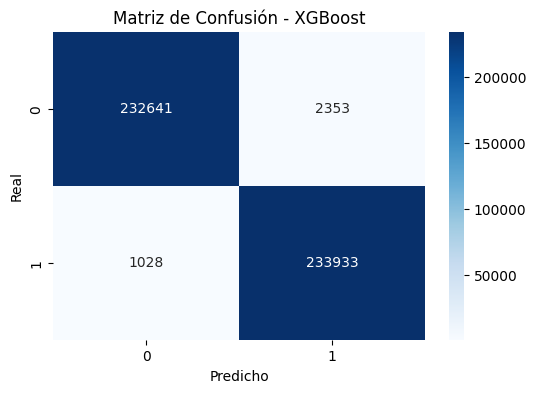

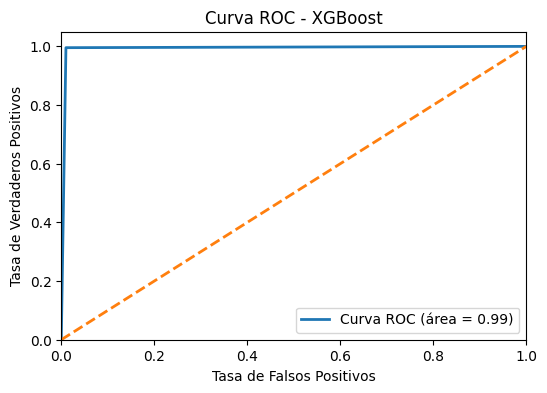

c:\Users\javi2\Desktop\MUII\DISIA\Proyecto\git\Bank-Fraud-Detection\venv\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


--- Resultados para KNN ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    234994
           1       0.98      1.00      0.99    234961

    accuracy                           0.99    469955
   macro avg       0.99      0.99      0.99    469955
weighted avg       0.99      0.99      0.99    469955



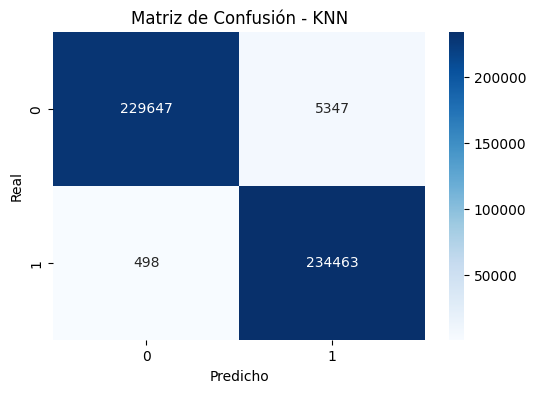

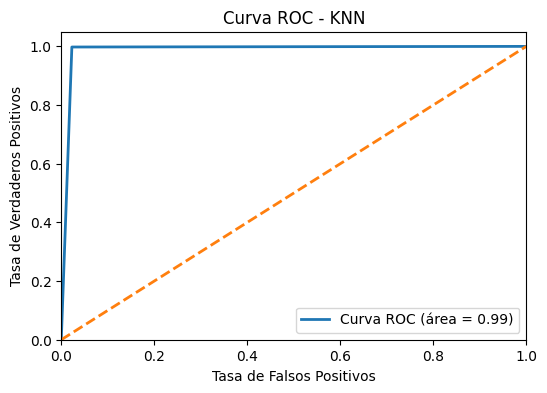

c:\Users\javi2\Desktop\MUII\DISIA\Proyecto\git\Bank-Fraud-Detection\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


--- Resultados para Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    234994
           1       0.99      1.00      0.99    234961

    accuracy                           0.99    469955
   macro avg       0.99      0.99      0.99    469955
weighted avg       0.99      0.99      0.99    469955



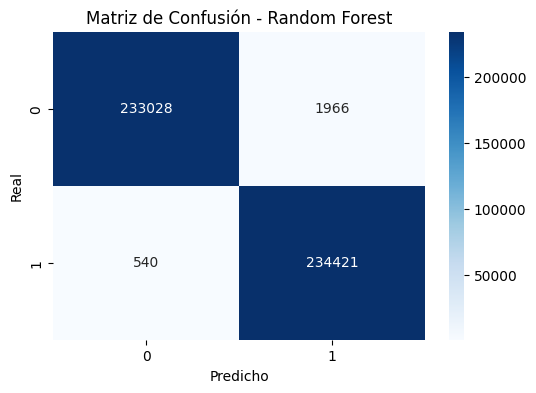

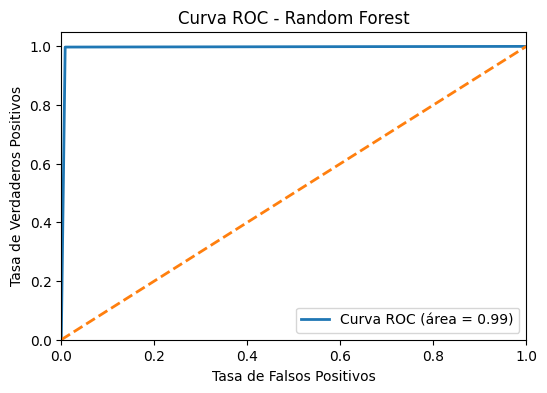

In [108]:
# Diccionario de modelos
modelos = {
    'XGBoost': xgb_model,
    'KNN': knn_model,
    'Random Forest': rf_model
}

for nombre, modelo in modelos.items():
    # Entrenar el modelo
    modelo.fit(X_train, y_train)
    # Predicciones
    y_pred_model = modelo.predict(X_test)
    
    # Reporte de clasificación
    print(f"--- Resultados para {nombre} ---")
    print(classification_report(y_test, y_pred_model))
    
    # Matriz de confusión
    cm_model = confusion_matrix(y_test, y_pred_model)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_model, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()
    
    # Curva ROC
    fpr_model, tpr_model, _ = roc_curve(y_test, y_pred_model)
    roc_auc_model = auc(fpr_model, tpr_model)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_model, tpr_model, lw=2, label=f'Curva ROC (área = {roc_auc_model:.2f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {nombre}')
    plt.legend(loc="lower right")
    plt.show()


AHORA SIN UTILIZAR SMOTE, SOLO LOS DATOS ORIGINALES

In [109]:
X_res = X
y_res = Y

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    235063
           1       0.91      0.72      0.81      2795

    accuracy                           1.00    237858
   macro avg       0.95      0.86      0.90    237858
weighted avg       1.00      1.00      1.00    237858



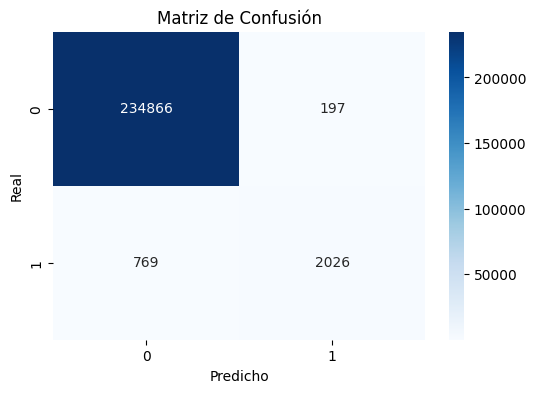

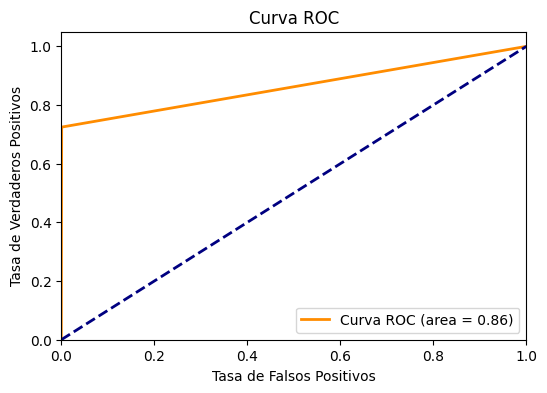

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.4, random_state=42)

# Modelos
xgb_model = xgb.XGBClassifier()
knn_model = KNeighborsClassifier(n_neighbors=3)
rf_model = RandomForestClassifier(n_estimators=100)

# Ensamble. Esto es un clasificador que combina los tres modelos anteriores. ¿Cómo funciona? El ensamble toma las predicciones de cada modelo y las combina para obtener una predicción final. En este caso, se utiliza la votación suave (soft voting), que consiste en promediar las probabilidades de cada modelo y seleccionar la clase con mayor probabilidad.
ensemble = VotingClassifier(estimators=[
    ('xgb', xgb_model), ('knn', knn_model), ('rf', rf_model)
], voting='soft')

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

--- Resultados para XGBoost ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    235063
           1       0.88      0.77      0.82      2795

    accuracy                           1.00    237858
   macro avg       0.94      0.88      0.91    237858
weighted avg       1.00      1.00      1.00    237858



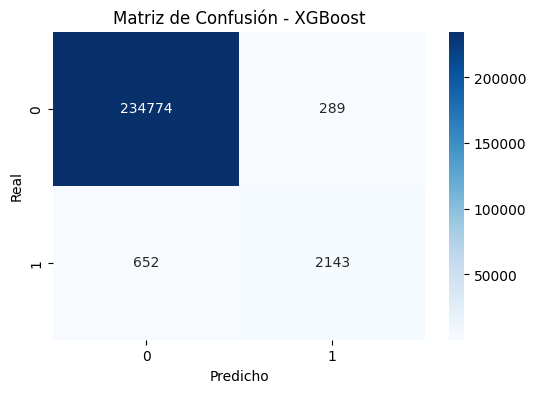

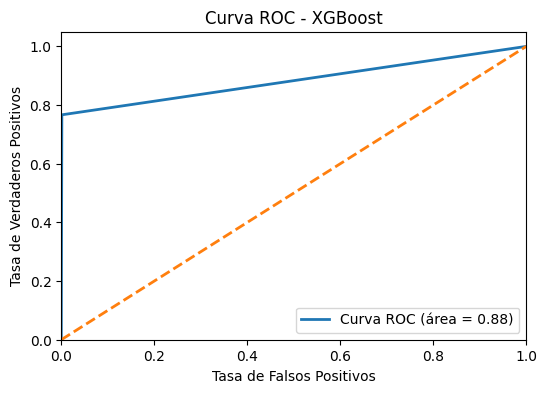

--- Resultados para KNN ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    235063
           1       0.78      0.62      0.69      2795

    accuracy                           0.99    237858
   macro avg       0.89      0.81      0.84    237858
weighted avg       0.99      0.99      0.99    237858



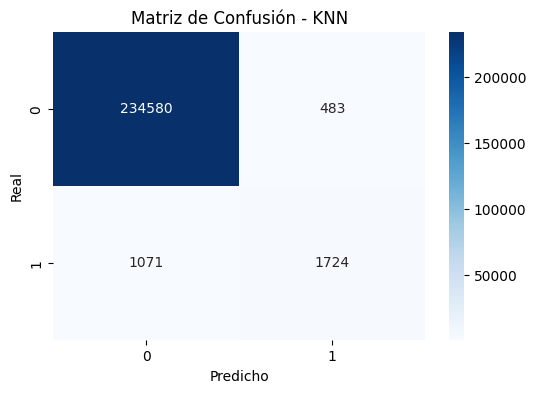

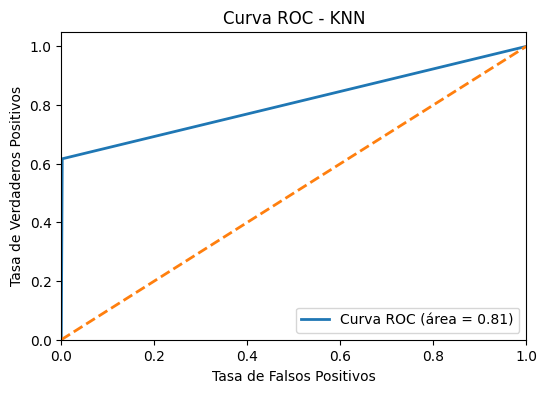

--- Resultados para Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    235063
           1       0.88      0.76      0.81      2795

    accuracy                           1.00    237858
   macro avg       0.94      0.88      0.91    237858
weighted avg       1.00      1.00      1.00    237858



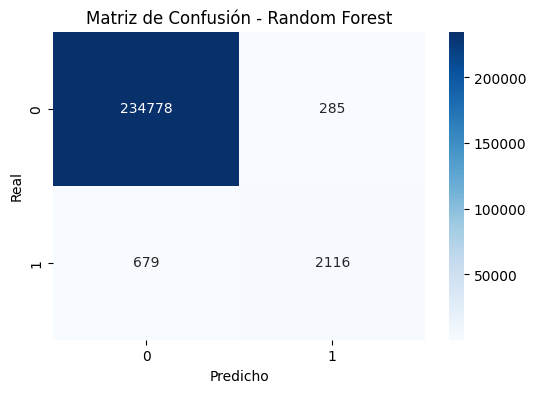

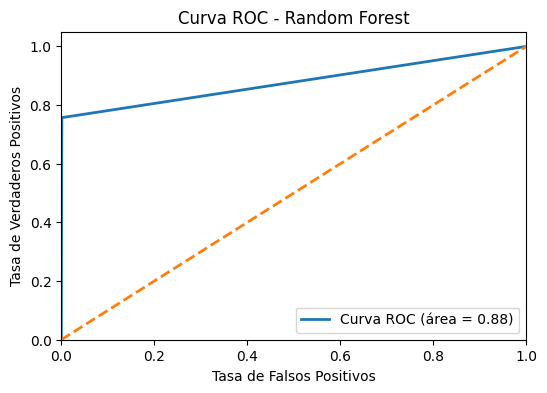

In [111]:
# Diccionario de modelos
modelos = {
    'XGBoost': xgb_model,
    'KNN': knn_model,
    'Random Forest': rf_model
}

for nombre, modelo in modelos.items():
    # Entrenar el modelo
    modelo.fit(X_train, y_train)
    # Predicciones
    y_pred_model = modelo.predict(X_test)
    
    # Reporte de clasificación
    print(f"--- Resultados para {nombre} ---")
    print(classification_report(y_test, y_pred_model))
    
    # Matriz de confusión
    cm_model = confusion_matrix(y_test, y_pred_model)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_model, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()
    
    # Curva ROC
    fpr_model, tpr_model, _ = roc_curve(y_test, y_pred_model)
    roc_auc_model = auc(fpr_model, tpr_model)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_model, tpr_model, lw=2, label=f'Curva ROC (área = {roc_auc_model:.2f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {nombre}')
    plt.legend(loc="lower right")
    plt.show()
